In [27]:
%load_ext autoreload
%autoreload 2

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

from utils.misc import *


%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# load and convert data, describe problem settings, etc
data_dir_path = './inputs/toy_data/'
path_L1 = os.path.join(data_dir_path, 'L1.csv')
path_L2 = os.path.join(data_dir_path, 'L2.csv')
path_L3 = os.path.join(data_dir_path, 'L3.csv')
path_U = os.path.join(data_dir_path, 'U.csv')

df_L1 = pd.read_csv(path_L1, index_col=0)
df_L2 = pd.read_csv(path_L2, index_col=0)
df_L3 = pd.read_csv(path_L3, index_col=0)
df_U = pd.read_csv(path_U, index_col=0)

L1 = np.array(df_L1)
L2 = np.array(df_L2)
L3 = np.array(df_L3)

L = np.stack([L1, L2, L3]) # data for pointwise constraint
U = np.array(df_U) # data for logical constriant

len_j = 3 # number of tasks (p の数)
len_h = 2 # number of logical constraints considered (cardinality of KB)

len_l = 4
len_u = 6
len_s = 10

len_jl = 0 # number of pointwise constraints to be counted later


len_l_list = [] # L_j の要素数のリスト
len_s_list = [] # S_j の要素数のリスト
S = [] # data for consistency constraints 

for i in range(len_j):
    if len_h != 0:
        u = len(U)
        S_i = np.concatenate((L[i][:, :2], U), axis=0)
        S.append(S_i)
    else:
        u = 0
        S_i = L[i][:, :2]
        S.append(S_i)
    len_l_list.append(len(L[i]))
    len_jl += len(L[i])
    len_s_list.append(len(S_i))

S = np.stack(S)


c1 = 2.5 # degree of satisfaction for pointwise slacks
c2 = 2.5 # degree of satisfaction for logical slacks


w_j = cp.Variable(shape=(len_j, 3))
xi_j_l = cp.Variable(shape=(len_j, len_l), nonneg=True)
xi_h = cp.Variable(shape=(len_h, 1), nonneg=True)



# 目的関数
function = 0

for j in range(len_j):
    w = w_j[j]
    function += 1/2 * (cp.norm2(w) ** 2)

for j in range(len_j):
    for l in range(len_l):
        xi = xi_j_l[j, l]
        function += c1 * xi

for h in range(len_h):
    xi = xi_h[h, 0]
    function += c2 * xi

objective_function = cp.Minimize(function)



# 制約
constraints = []

class Predicate:
    def __init__(self, w):
        self.w1 = w[0]
        self.w2 = w[1]
        self.b = w[2]

    def func(self, x):
        x1, x2 = x[0], x[1]
        return self.w1 * x1 + self.w2 * x2 + self.b
    
    def __call__(self, x):
        x1, x2 = x[0], x[1]
        return self.w1 * x1 + self.w2 * x2 + self.b

# def predicate(x, w):
#     x1, x2 = x[0], x[1]
#     w1, w2, b = w[0], w[1], w[2]

#     return w1 * x1 + w2 * x2 + b


# pointwise
for j in range(len_j):
    w = w_j[j]
    p = Predicate(w).func 
    # p = predicate

    for l in range(len_l):
        x = L[j][l, :2]
        y = L[j][l, 2]

        xi = xi_j_l[j, l]

        constraints += [
            y * (2 * p(x) - 1) >= 1 - 2 * xi
            # y * (2 * p(x, w) - 1) >= 1 - 2 * xi
        ]


# # logical
# for h in range(len_h):
#     w_1 = w_j[h]
#     w_2 = w_j[h + 1]

#     p_j = Predicate(w_1).func
#     p_k = Predicate(w_2).func
#     # p = predicate

#     xi = xi_h[h, 0]

#     for u in range(len_u):
#         x = U[u]

#         constraints += [
#             p_j(x) - p_k(x) <= xi,
#             # p(x, w_1) - p(x, w_2) <= xi,
#         ]

# logical
for u in range(len_u):
    x = U[u]

    for h in range(len_h):
        w_1 = w_j[h]
        w_2 = w_j[h + 1]

        p_j = Predicate(w_1).func
        p_k = Predicate(w_2).func

        xi = xi_h[h, 0]

        constraints += [
            p_j(x) - p_k(x) <= xi
        ]


# consistency
for j in range(len_j):
    w = w_j[j]
    p = Predicate(w).func
    # p = predicate

    for s in range(len_s):
        x = S[j][s]

        constraints += [
            p(x) >= 0,
            p(x) <= 1,
            # p(x, w) >= 0,
            # p(x, w) <= 1,
        ]


problem = cp.Problem(objective_function, constraints)
result = problem.solve(verbose=True)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Oct 15 12:27:04 PM: Your problem has 23 variables, 84 constraints, and 0 parameters.
(CVXPY) Oct 15 12:27:04 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 15 12:27:04 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 15 12:27:04 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 15 12:27:04 PM: Compiling problem (target solver=ECOS).
(CVXPY) Oct 15 12:27:04 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

(CVXPY) Oct 15 12:27:04 PM: Applying reduction CvxAttr2Constr
(CVXPY) Oct 15 12:27:04 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Oct 15 12:27:04 PM: Applying reduction ECOS
(CVXPY) Oct 15 12:27:04 PM: Finished problem compilation (took 1.846e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Oct 15 12:27:04 PM: Invoking solver ECOS  to obtain a solution.

ECOS 2.0.10 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +7.166e+00  -3.598e+01  +3e+02  5e-01  8e-01  1e+00  3e+00    ---    ---    1  1  - |  -  - 
 1  +4.915e+00  -8.971e+00  +2e+02  2e-01  3e-01  1e+00  2e+00  0.5600  2e-01   1  1  1 |  0  0
 2  +7.270e+00  +2.527e+00  +7e+01  5e-02  9e-

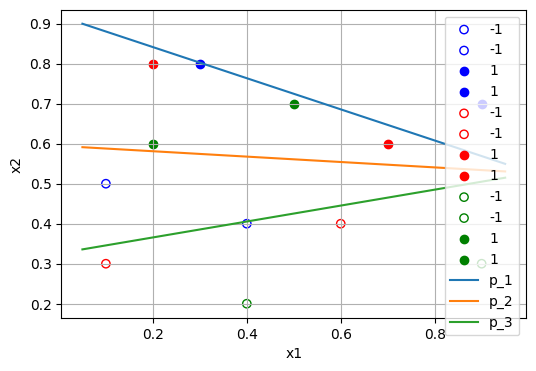

In [19]:
coeff_0 = w_j.value[0]
coeff_1 = w_j.value[1]
coeff_2 = w_j.value[2]
coeffs = [coeff_0, coeff_1, coeff_2]


def boundary_equation_2d(x1, coeff):
    w1 = coeff[0]
    w2 = coeff[1]
    b = coeff[2]

    x = np.hstack([x1, np.ones_like(x1)])
    # w = np.array([-w1/w2, -b/w2]).reshape(-1,1)
    w = np.array([-w1/w2, -b/w2 + 0.5/w2]).reshape(-1,1)

    return x @ w

test_x = np.linspace(0.05, 0.95, 100).reshape(-1,1)

test_y_1 = boundary_equation_2d(test_x, coeff_0)
test_y_2 = boundary_equation_2d(test_x, coeff_1)
test_y_3 = boundary_equation_2d(test_x, coeff_2)



plt.figure(figsize=(6,4))
colors = ['blue', 'red', 'green']

for j in range(len_j):
    for l in range(4):
        if L[j][l, 2] == 1:
            plt.scatter(L[j][l, 0], L[j][l, 1], c=colors[j], marker='o', label='1')
        else:
            plt.scatter(L[j][l, 0], L[j][l, 1], facecolors='none', edgecolors=colors[j], marker='o', label='-1')

plt.plot(test_x, test_y_1, label="p_1")
plt.plot(test_x, test_y_2, label="p_2")
plt.plot(test_x, test_y_3, label="p_3")


plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
import copy

In [22]:
var1 = cp.Variable()
var2 = cp.Variable()

print(var1)
print(var2)

var11875
var11876


In [25]:
tmp = [var1, var1]

for item in tmp:
    print(item)

var11875
var11875


In [26]:
copy.copy(tmp)

[Variable(()), Variable(())]

In [4]:
for constraint in constraints:
    print(constraint)

1.0 + -2.0 @ var2[0, 0] <= -1.0 @ (2.0 @ (var1[0, 0:3][0] @ 0.1 + var1[0, 0:3][1] @ 0.5 + var1[0, 0:3][2]) + -1.0)
1.0 + -2.0 @ var2[0, 1] <= -1.0 @ (2.0 @ (var1[0, 0:3][0] @ 0.4 + var1[0, 0:3][1] @ 0.4 + var1[0, 0:3][2]) + -1.0)
1.0 + -2.0 @ var2[0, 2] <= 1.0 @ (2.0 @ (var1[0, 0:3][0] @ 0.3 + var1[0, 0:3][1] @ 0.8 + var1[0, 0:3][2]) + -1.0)
1.0 + -2.0 @ var2[0, 3] <= 1.0 @ (2.0 @ (var1[0, 0:3][0] @ 0.9 + var1[0, 0:3][1] @ 0.7 + var1[0, 0:3][2]) + -1.0)
1.0 + -2.0 @ var2[1, 0] <= -1.0 @ (2.0 @ (var1[1, 0:3][0] @ 0.1 + var1[1, 0:3][1] @ 0.3 + var1[1, 0:3][2]) + -1.0)
1.0 + -2.0 @ var2[1, 1] <= -1.0 @ (2.0 @ (var1[1, 0:3][0] @ 0.6 + var1[1, 0:3][1] @ 0.4 + var1[1, 0:3][2]) + -1.0)
1.0 + -2.0 @ var2[1, 2] <= 1.0 @ (2.0 @ (var1[1, 0:3][0] @ 0.2 + var1[1, 0:3][1] @ 0.8 + var1[1, 0:3][2]) + -1.0)
1.0 + -2.0 @ var2[1, 3] <= 1.0 @ (2.0 @ (var1[1, 0:3][0] @ 0.7 + var1[1, 0:3][1] @ 0.6 + var1[1, 0:3][2]) + -1.0)
1.0 + -2.0 @ var2[2, 0] <= -1.0 @ (2.0 @ (var1[2, 0:3][0] @ 0.4 + var1[2, 0:3][1] @ 

In [12]:
print(objective_function)

minimize 0.5 @ power(Pnorm(var1[0, 0:3], 2), 2.0) + 0.5 @ power(Pnorm(var1[1, 0:3], 2), 2.0) + 0.5 @ power(Pnorm(var1[2, 0:3], 2), 2.0) + 100.0 @ var2[0, 0] + 100.0 @ var2[0, 1] + 100.0 @ var2[0, 2] + 100.0 @ var2[0, 3] + 100.0 @ var2[1, 0] + 100.0 @ var2[1, 1] + 100.0 @ var2[1, 2] + 100.0 @ var2[1, 3] + 100.0 @ var2[2, 0] + 100.0 @ var2[2, 1] + 100.0 @ var2[2, 2] + 100.0 @ var2[2, 3] + 100.0 @ var3[0, 0] + 100.0 @ var3[1, 0]


In [11]:
w_j.value

array([[ 7.50000000e-01,  2.00000000e+00, -1.07500000e+00],
       [ 3.19767442e-01,  1.93604651e+00, -6.12790698e-01],
       [ 1.73122236e-11,  2.00000000e+00, -4.00000000e-01]])

In [9]:
print(xi_j_l)

var2


In [8]:
print(xi_h)

var3


In [6]:
xi_h.value

array([[9.47138399e-11],
       [7.49999999e-02]])

In [7]:
xi_j_l.value

array([[0.        , 0.025     , 0.25      , 0.        ],
       [0.        , 0.35348837, 0.        , 0.22732558],
       [0.        , 0.2       , 0.2       , 0.        ]])

In [ ]:
-var1[1, 0:3][0] @ 0.1 + 
var1[0, 0:3][0] @ 0.1 + 
var1[0, 0:3][1] @ 0.5 + 
var1[0, 0:3][2] + 
var1[1, 0:3][1] @ 0.5 + 
var1[1, 0:3][2] <= 
var3[0, 0]

In [ ]:
var1[0, 0:3][0] @ 0.1 + var1[0, 0:3][1] @ 0.5 + var1[0, 0:3][2] + -var1[1, 0:3][0] @ 0.1 + var1[1, 0:3][1] @ 0.5 + var1[1, 0:3][2] <= var3[0, 0]
var1[0, 0:3][0] @ 0.3 + var1[0, 0:3][1] @ 0.7 + var1[0, 0:3][2] + -var1[1, 0:3][0] @ 0.3 + var1[1, 0:3][1] @ 0.7 + var1[1, 0:3][2] <= var3[0, 0]
var1[0, 0:3][0] @ 0.5 + var1[0, 0:3][1] @ 0.4 + var1[0, 0:3][2] + -var1[1, 0:3][0] @ 0.5 + var1[1, 0:3][1] @ 0.4 + var1[1, 0:3][2] <= var3[0, 0]
var1[0, 0:3][0] @ 0.8 + var1[0, 0:3][1] @ 0.3 + var1[0, 0:3][2] + -var1[1, 0:3][0] @ 0.8 + var1[1, 0:3][1] @ 0.3 + var1[1, 0:3][2] <= var3[0, 0]
var1[0, 0:3][0] @ 0.9 + var1[0, 0:3][1] @ 0.2 + var1[0, 0:3][2] + -var1[1, 0:3][0] @ 0.9 + var1[1, 0:3][1] @ 0.2 + var1[1, 0:3][2] <= var3[0, 0]
var1[0, 0:3][0] @ 1.0 + var1[0, 0:3][1] @ 0.5 + var1[0, 0:3][2] + -var1[1, 0:3][0] @ 1.0 + var1[1, 0:3][1] @ 0.5 + var1[1, 0:3][2] <= var3[0, 0]
var1[1, 0:3][0] @ 0.1 + var1[1, 0:3][1] @ 0.5 + var1[1, 0:3][2] + -var1[2, 0:3][0] @ 0.1 + var1[2, 0:3][1] @ 0.5 + var1[2, 0:3][2] <= var3[1, 0]
var1[1, 0:3][0] @ 0.3 + var1[1, 0:3][1] @ 0.7 + var1[1, 0:3][2] + -var1[2, 0:3][0] @ 0.3 + var1[2, 0:3][1] @ 0.7 + var1[2, 0:3][2] <= var3[1, 0]
var1[1, 0:3][0] @ 0.5 + var1[1, 0:3][1] @ 0.4 + var1[1, 0:3][2] + -var1[2, 0:3][0] @ 0.5 + var1[2, 0:3][1] @ 0.4 + var1[2, 0:3][2] <= var3[1, 0]
var1[1, 0:3][0] @ 0.8 + var1[1, 0:3][1] @ 0.3 + var1[1, 0:3][2] + -var1[2, 0:3][0] @ 0.8 + var1[2, 0:3][1] @ 0.3 + var1[2, 0:3][2] <= var3[1, 0]
var1[1, 0:3][0] @ 0.9 + var1[1, 0:3][1] @ 0.2 + var1[1, 0:3][2] + -var1[2, 0:3][0] @ 0.9 + var1[2, 0:3][1] @ 0.2 + var1[2, 0:3][2] <= var3[1, 0]
var1[1, 0:3][0] @ 1.0 + var1[1, 0:3][1] @ 0.5 + var1[1, 0:3][2] + -var1[2, 0:3][0] @ 1.0 + var1[2, 0:3][1] @ 0.5 + var1[2, 0:3][2] <= var3[1, 0]